## Load the required libraries

In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob 
import cv2
from skimage.io import imread 
import os
import shutil
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications import MobileNetV2
from keras.applications.xception import Xception
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras

## Data Exploration

In [2]:
#load the dataset and look at the number of training and testing examples

print('Train Images = ',len(os.listdir('/Users/Shambhavi Malik/Desktop/Cancer Detection/train/')))
print('Test Images = ',len(os.listdir('/Users/Shambhavi Malik/Desktop/Cancer Detection/test/')))

Train Images =  220025
Test Images =  57458


In [3]:
#create a dataframe of train image labels

df = pd.read_csv('/Users/Shambhavi Malik/Desktop/Cancer Detection/train_labels.csv')
print('Shape of DataFrame',df.shape)

df.head()

Shape of DataFrame (220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


We are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. 

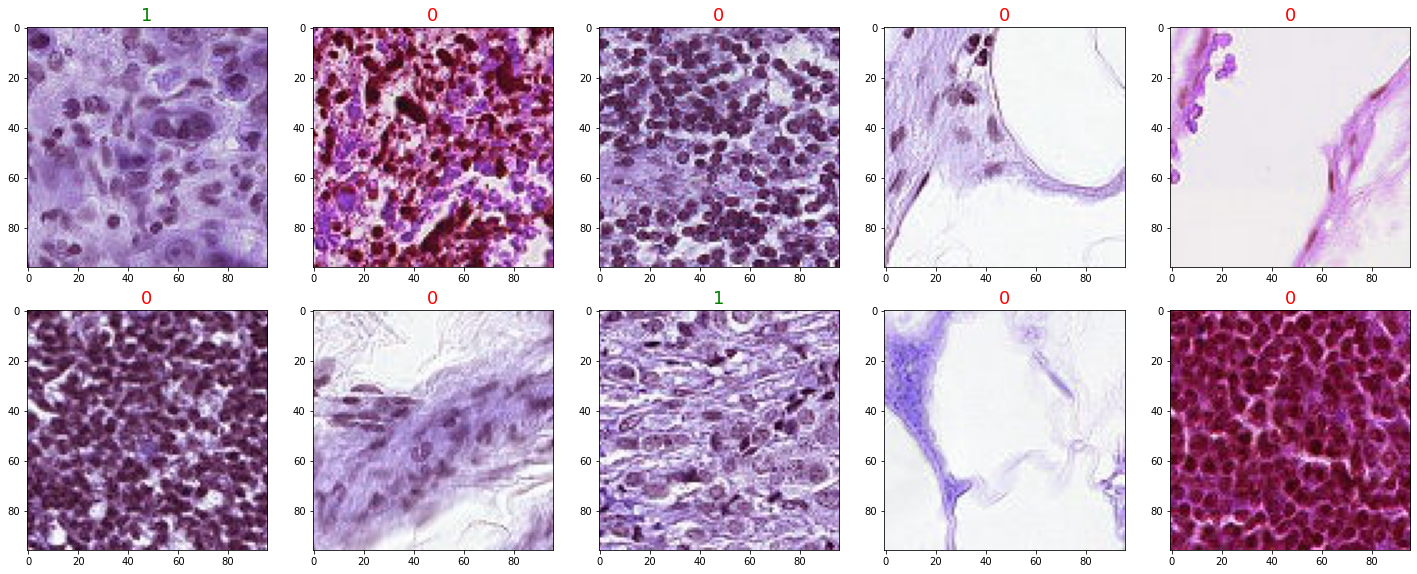

In [4]:
#visualise training examples
training_dir = '/Users/Shambhavi Malik/Desktop/Cancer Detection/train/'

fig = plt.figure(figsize = (20,8))
index = 1
for i in np.random.randint(low = 0, high = df.shape[0], size = 10):
    file = training_dir + df.iloc[i]['id'] + '.tif'
    img = cv2.imread(file)
    ax = fig.add_subplot(2, 5, index)
    ax.imshow(img, cmap = 'gray')
    index = index + 1
    color = ['green' if df.iloc[i].label == 1 else 'red'][0]
    ax.set_title(df.iloc[i].label, fontsize = 18, color = color)
plt.tight_layout()
plt.show()

## Feature engineering


In [5]:
# take a sample size of 85000 to avoid crashing
SAMPLE_SIZE = 85000

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df[df['label'] == 0].sample(SAMPLE_SIZE, random_state = 0)
# filter out class 1
df_1 = df[df['label'] == 1].sample(SAMPLE_SIZE, random_state = 0)

# concat the dataframes
df_train = pd.concat([df_0, df_1], axis = 0).reset_index(drop = True)

# shuffle
df_train.sample(frac=1)

df_train['label'].value_counts()

1    85000
0    85000
Name: label, dtype: int64

In [6]:
df_train.head()

,id,label
0,4d03f037381aa81370f4ef724cece830910be6e2,0
1,fe6129053d73422aa1c3ba03b41deacf68d2d27b,0
2,dd752745021474b0752095c8d6c8af72ea9f40ea,0
3,514deb337e49c9ba0cc3d20f990b47799059c72c,0
4,4a20631d20270b4b5e97eaeeba85e9b7f09337af,0


In [7]:
df_train.tail()

,id,label
169995,465a70e648cd5f414e584798d349f603a584980e,1
169996,d1a0ca789344beabd2e4c7f26a3f0ec6251daf98,1
169997,970530056fad2be4b994d07f3142317a3bc65986,1
169998,05ce96e76de1558ada854e01ac6a0f5a926c04f6,1
169999,3b3cded61e61f33b91bdfa0a9aab73f6ad0da7be,1


In [8]:
# split into training and validation sets
y = df_train['label']
df_train, df_val = train_test_split(df_train, test_size = 0.1, random_state = 0, stratify = y)

In [ ]:
# Create a new directory
b_dir = 'b_dir'
os.mkdir(b_dir)


#Folder Structure

'''
    * b_dir
        |-- trn_dir
            |-- 0   #No Tumor (negative)
            |-- 1   #Has Tumor (positive)
        |-- v_dir
            |-- 0
            |-- 1
'''
# create a path to 'b_dir' to which we will join the names of the new folders
# trn_dir
trn_dir = os.path.join(b_dir, 'trn_dir')
os.mkdir(trn_dir)

# v_dir
v_dir = os.path.join(b_dir, 'v_dir')
os.mkdir(v_dir)

# create new folders inside trn_dir
neg = os.path.join(trn_dir, '0')
os.mkdir(neg)
pos = os.path.join(trn_dir, '1')
os.mkdir(pos)


# create new folders inside v_dir
neg = os.path.join(v_dir, '0')
os.mkdir(neg)
pos = os.path.join(v_dir, '1')
os.mkdir(pos)

print(os.listdir('b_dir/trn_dir'))
print(os.listdir('b_dir/v_dir'))

In [ ]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    file_name = image + '.tif'
    # get the label for a certain image
    target = df.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = '0'
    elif target == 1:
        label = '1'
    
    # source path to image
    src = os.path.join('/Users/Shambhavi Malik/Desktop/Cancer Detection/train', file_name)
    # destination path to image
    dest = os.path.join(trn_dir, label, file_name)
    # copy the image from the source to the destination
    shutil.copyfile(src, dest)

In [ ]:
for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    file_name = image + '.tif'
    # get the label for a certain image
    target = df.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = '0'
    elif target == 1:
        label = '1'
    

    # source path to image
    src = os.path.join('/Users/Shambhavi Malik/Desktop/Cancer Detection/train', file_name)
    # destination path to image
    dest = os.path.join(v_dir, label, file_name)
    # copy the image from the source to the destination
    shutil.copyfile(src, dest)

In [9]:
print(len(os.listdir('b_dir/trn_dir/0')))
print(len(os.listdir('b_dir/trn_dir/1')))

72000
72000


## Data Augmentation

In [10]:
data_augmentation = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       rotation_range=180,
                                       zoom_range=0.4, 
                                       width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       shear_range=0.3,
                                       channel_shift_range=0.3)

In [11]:
batch_size = 192
image_size = 96

train_path = 'b_dir/trn_dir'
val_path = 'b_dir/v_dir'
test_path = '/Users/Shambhavi Malik/Desktop/Cancer Detection/test'

train_set = data_augmentation.flow_from_directory(train_path,
                                                            target_size = (image_size,image_size),
                                                            batch_size = batch_size,
                                                            class_mode = 'binary')
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size = (image_size,image_size),
                                                                        batch_size = batch_size,
                                                                        class_mode = 'binary')
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                           target_size = (image_size,image_size),
                                                                           batch_size = batch_size,
                                                                           class_mode = 'binary',
                                                                           shuffle = False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


## Model

In [16]:
input_shape = (image_size, image_size, 3)
inputs = Input(input_shape)

xception = Xception(include_top = False, input_shape= input_shape)(inputs)
mobile_net = MobileNetV2(include_top = False, input_shape= input_shape)(inputs)

outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(xception), GlobalAveragePooling2D()(mobile_net)])
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 3, 3, 2048)   20861480    input_9[0][0]                    
__________________________________________________________________________________________________
mobilenetv2_1.00_96 (Functional (None, 3, 3, 1280)   2257984     input_9[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_4 (Glo (None, 2048)         0           xception[0][0]                   
_______________________________________________________________________________________

In [ ]:
history = model.fit_generator(train_set,
                              steps_per_epoch=len(train_set), 
                              validation_data=val_set,
                              validation_steps=len(val_set),
                              epochs=10,
                              verbose=1,
                              callbacks=PlotLossesKeras())

The dataset is such that the outer region of each image is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image. Therefore, we need not use ZeroPadding for our model.

## Training

In [ ]:
# Training

history = model.fit_generator(train_set, 
                              validation_data=val_set,
                              steps_per_epoch=len(train_set)/batch_size ,
                              validation_steps=len(val_set)/batch_size, 
                              epochs = 15,
                              verbose = 1,
                              )

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()